# Custom_CNN

In [ ]:
import os, sys, math, time, json, random
from pathlib import Path
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps, ImageEnhance
from torchvision import datasets, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F

## Configuration

In [ ]:
batch_size = 32
img_size = 224
epochs = 30
lr = 3e-4
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Data Loadder

In [ ]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

data_dir = "../aug-data"

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val", "test"]
}

class_names = image_datasets["train"].classes
print("Classes:", class_names)

Classes: ['Anthracnose', 'Canker', 'Dot', 'Healthy', 'Rust']


## Display some augmented images

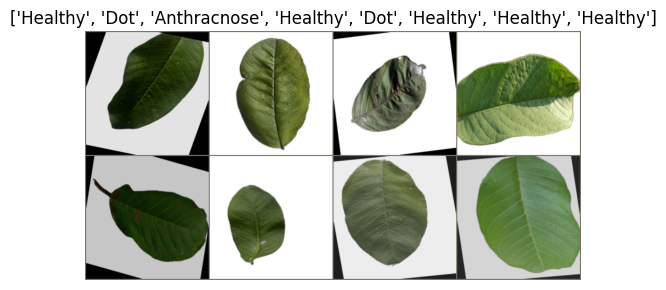

In [29]:
def imshow(inp, title=None):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    inp = inp * std[:, None, None] + mean[:, None, None]

    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


def show_batch(loader):
    inputs, classes = next(iter(loader))
    out = torchvision.utils.make_grid(inputs[:8], nrow=4)
    imshow(out, title=[class_names[x] for x in classes[:8]])

show_batch(dataloaders['train'])

## Custom CNN

In [30]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = float('inf')
        self.early_stop = False
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

## Optimizer and Scaler

In [ ]:
num_classes = len(class_names)
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(enabled=(device.type == "cuda"))

## Training using Custom CNN (Using AMP)

In [ ]:

train_losses, val_losses, val_f1s = [], [], []
best_f1 = -1.0
best_path = "../local_saved_model/custom_cnn_best.pth"
y_true, y_pred = [], []

def run_epoch(loader, model, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0

    pbar = tqdm(loader, total=len(loader))
    for images, labels in pbar:
        images = images.to(device, non_blocking=True).float()
        labels = torch.as_tensor(labels, device=device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1).detach().cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())

    epoch_loss = running_loss / len(loader.dataset)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1 = report['weighted avg']['f1-score']
    return epoch_loss, f1, report

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    tr_loss, tr_f1, _ = run_epoch(dataloaders["train"], model, train=True)
    with torch.no_grad():
        val_loss, val_f1, val_report = run_epoch(dataloaders["val"], model, train=False)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    scheduler.step(val_loss)

    print(f"  train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_f1={val_f1:.4f} | lr={optimizer.param_groups[0]['lr']:.2e}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), best_path)
        print(f" New best F1: {best_f1:.4f} — saved to {best_path}")

    if early_stopping.step(val_loss):
        print(" Early stopping triggered.")
        break


## Plotting Loss Curve

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss (Custom_CNN)")
plt.show()

## Test Evalution

In [ ]:
if Path(best_path).exists():
    model.load_state_dict(torch.load(best_path, map_location=device))

with torch.no_grad():
    test_loss, test_f1, test_report = run_epoch(dataloaders["test"], model, train=False)

print("Test F1:", test_f1)
print(json.dumps(test_report, indent=2))

## XAI

### Load model and Predict

In [ ]:
model = CustomCNN()
model.load_state_dict(torch.load("custom_cnn_best.pth", map_location=device))
model.to(device)
model.eval()

idx = random.randint(0, len(dataloaders["test"]) - 1)
image, label = dataloaders["test"].dataset[idx]
input_tensor = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, 1).item()

print(f"True Label: {label}, Predicted: {pred_class}")

### Grad-CAM visualizations

In [ ]:
rgb_img = image.permute(1, 2, 0).numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

try:
    target_layers = [model.features[-5]]
except AttributeError:
    target_layers = [list(model.children())[-1]]

cams = {
    "Grad-CAM": GradCAM(
        model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()
    ),
    "Grad-CAM++": GradCAMPlusPlus(
        model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()
    ),
    "Eigen-CAM": EigenCAM(
        model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()
    ),
    "Ablation-CAM": AblationCAM(
        model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()
    ),
}

fig, axs = plt.subplots(1, len(cams) + 1, figsize=(20, 5))
axs[0].imshow(rgb_img)
axs[0].set_title("Original")
axs[0].axis("off")

for i, (name, cam_algo) in enumerate(cams.items(), 1):
    grayscale_cam = cam_algo(
        input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)]
    )[0, :]
    cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    axs[i].imshow(cam_img)
    axs[i].set_title(name)
    axs[i].axis("off")

plt.show()

### Lime Visualization

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([transforms.ToTensor()(img) for img in images], dim=0).to(
        device
    )
    with torch.no_grad():
        logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.cpu().numpy()


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    (rgb_img * 255).astype(np.uint8),
    batch_predict,
    labels=(pred_class,),
    hide_color=0,
    num_samples=1000,
)

lime_img, mask = explanation.get_image_and_mask(
    pred_class, positive_only=False, hide_rest=False
)
plt.imshow(mark_boundaries(lime_img, mask))
plt.title("LIME")
plt.axis("off")
plt.show()